## Easy Experiment .ipynb File

# <font color='red'><b> 🐬 기억합시다 :] 실험마다 인덱스 붙여서 파일 새로만들기~! <b></font>

# train

## import

In [1]:
!nvidia-smi

Sun Oct 30 13:58:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   36C    P0    35W / 250W |  27139MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random
import time
from datetime import timedelta

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [3]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [4]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [5]:
### cofiguration
seed = 17
check_point_dir_name = 'convnext_age_regression'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/3head_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 500
train_ratio = 0.7
epochs = 30
print_interval = 414 # 414
lr = 3e-4
model_name = 'convnext_tiny'
num_labels = '의미없음'
loss_function_name = 'MSELoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
weight_decay = 0.02
scheduler_name = 'CosineAnnealingWarmRestarts'
comment = f'convnext를 이용한 age regressor'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

```
,path,mask_class,gender_class,age,origin_label
```  

In [6]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
mask = train_df['mask_class']
gender = train_df['gender_class']
age = train_df['age']

stratify_col = train_df['origin_label']

train_paths, valid_paths, \
    train_masks, valid_masks,\
        train_genders, valid_genders,\
            train_ages, valid_ages = train_test_split(imgs_path, mask, gender, age,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

In [7]:
len(valid_genders)

5670

In [8]:
os.makedirs(save_dir,exist_ok=True)

In [9]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : lr,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'weight_decay' : weight_decay,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [10]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [11]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, 
                 img_paths : pd.Series, 
                 mask_labels : pd.Series, 
                 gender_labels:pd.Series, 
                 age_labels:pd.Series, 
                 transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        self.mask_labels = mask_labels.to_numpy() # self.labels = pd.get_dummies(labels).to_numpy()
        self.gender_labels = gender_labels.to_numpy()
        self.age_labels = age_labels.to_numpy(np.float32)
        assert self.transforms != None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]

        return img, mask_label, gender_label, age_label

    def __len__(self):
        return len(self.img_paths)

## augmentations

In [12]:
train_transforms = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.5),
        A.CLAHE(),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

## make dataset and dataloader

In [13]:
train_dset = CustomTrainDataset(train_paths, train_masks, train_genders, train_ages, train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_masks, valid_genders, valid_ages, valid_transforms)

In [14]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

In [15]:
i, m, g, a = next(iter(train_loader))

In [16]:
print(i.size())
print(m.unsqueeze(dim=1).size())
print(g.size())
print(a.size())

torch.Size([32, 3, 224, 224])
torch.Size([32, 1])
torch.Size([32])
torch.Size([32])


## visualization transform

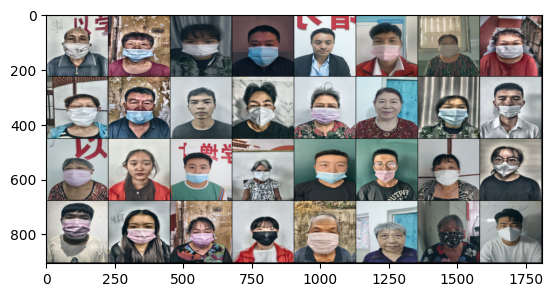

In [17]:
## for check transform
imgs, m, g, a = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [18]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=1)
model.to(device)
# model = torch.nn.DataParallel(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine

In [19]:
# def get_feature_extractor(model):
#         model = torch.nn.Sequential(*(list(model.children())[:-1]))
#         return model

# fe = get_feature_extractor(model)
# dummy = torch.Tensor(2,3,244,244)
# nn.Linear(1792,2)(fe(dummy)).size()

In [20]:
class ConvNextAgeRegressor(nn.Module):
    def __init__(self, original_nodel):
        super(ConvNextAgeRegressor, self).__init__()
        self.model = original_nodel
        self.model.head.fc = nn.Linear(768,1) # cnage fc layer to age regressor

    def forward(self, x):
        return self.model(x)

In [21]:
# model = ConvNextAgeRegressor(model).to(device)
# model.cuda()
dummy = torch.Tensor(2,3,244,244).to(device)
age_preds = model(dummy)

In [22]:
age_preds.size()

torch.Size([2, 1])

## Loss function

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [24]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
elif loss_function_name == 'F1Loss':
    criterion = F1Loss(classes=num_labels)
elif loss_function_name == 'MSELoss':
    pass
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

[difference_CE_BCE](https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23)  
I need probability so use CE

In [25]:
# criterion_mask = nn.CrossEntropyLoss()
# criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.MSELoss()

## Optimizer

In [26]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay) # 0.09 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

## Scheduler  

In [27]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    ## during 5epochs, valid loss decrease 1e-3↓, lr update lr*0.5
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-3) ## 정리
elif scheduler_name == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-4)

assert scheduler != None , 'sheduler is None'

## Train

In [28]:
def get_class(mask_state, gender_state, age_state, middle_start=30, senior_start=60):
    middle_start = 30
    senior_start = 60
    code = None
    if mask_state == 0 and gender_state == 0  and age_state<middle_start: # 0
        code = 0
    
    elif mask_state == 0 and gender_state == 0  and middle_start<=age_state<senior_start: # 1
        code = 1
    
    elif mask_state == 0 and gender_state == 0  and senior_start<=age_state: # 2
        code = 2
    
    elif mask_state == 0 and gender_state == 1  and age_state<middle_start: # 3
        code = 3
    
    elif mask_state == 0 and gender_state == 1  and middle_start<=age_state<senior_start: # 4
        code = 4
    
    elif mask_state == 0 and gender_state == 1  and senior_start<=age_state: # 5
        code = 5

    elif mask_state == 1 and gender_state == 0  and age_state<middle_start: # 6
        code = 6

    elif mask_state == 1 and gender_state == 0  and middle_start<=age_state<senior_start: # 7
        code = 7

    elif mask_state == 1 and gender_state == 0  and senior_start<=age_state: # 8
        code = 8

    elif mask_state == 1 and gender_state == 1  and age_state<middle_start: # 9
        code = 9

    elif mask_state == 1 and gender_state == 1  and middle_start<=age_state<senior_start: # 10
        code = 10

    elif mask_state == 1 and gender_state == 1  and senior_start<=age_state: # 11
        code = 11

    elif mask_state == 2 and gender_state == 0  and age_state<middle_start: # 12
        code = 12

    elif mask_state == 2 and gender_state == 0  and middle_start<=age_state<senior_start: # 13
        code = 13

    elif mask_state == 2 and gender_state == 0  and senior_start<=age_state: # 14
        code = 14

    elif mask_state == 2 and gender_state == 1  and age_state<middle_start: # 15
        code = 15

    elif mask_state == 2 and gender_state == 1  and middle_start<=age_state<senior_start: # 16
        code = 16

    elif mask_state == 2 and gender_state == 1  and senior_start<=age_state: # 17
        code = 17

    else:
        raise ValueError('unable encoding')
        
    return code

In [29]:
best_val_acc = 0
best_val_f1 = 0
best_val_MAE = np.Inf

list_total_preds = [] # full_preds
list_total_labels = [] # full_labels

start=time.process_time()

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    
    # epoch_mask_preds = []
    # epoch_mask_labels = []
    
    # epoch_gender_preds = []
    # epoch_gender_labels = []

    epoch_age_preds = []
    epoch_age_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, _, _, b_a_labels = train_batch # batch imgs and batch labels
        
        b_imgs = b_imgs.cuda()

        b_a_labels.to(torch.float32)
        b_a_labels = b_a_labels.to(device)


        age_preds = model(b_imgs)

        age_preds.to(device)

        b_a_labels = b_a_labels.unsqueeze(dim=1)
        b_age_loss = criterion_age(age_preds, b_a_labels)

        optimizer.zero_grad()
        b_age_loss.backward(retain_graph=True)
        optimizer.step()

        b_age_preds = age_preds


        epoch_age_preds += b_age_preds.squeeze().detach().cpu().numpy().tolist()
        epoch_age_labels += b_a_labels.squeeze().detach().cpu().numpy().tolist()


        # print interval batch
        if(idx+1) % print_interval == 0: # 주의
            current_loss = epoch_loss / (idx+1) # / batch

            age_diff = [abs(i-j) for i,j in zip(epoch_age_preds, epoch_age_labels)]
            age_MAE = sum(age_diff)/len(age_diff)

            pred_class = []
            label_class = []

            for a in epoch_age_preds:
                pred_class.append(a)

            for a in epoch_age_labels:
                label_class.append(a)
            
            # train_acc = (label_class,pred_class)
            # train_f1 = f1_score(label_class, pred_class, average='macro')

            print("Train score")
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"train age MAE {age_MAE:2.2f}"
                )
            # print(f"train acc {train_acc} || train f1 {train_f1}")
    scheduler.step()


    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()

        val_loss = []
        val_acc = []

        # val_mask_preds = [] # every data's preds
        # val_gender_preds = [] # every data's preds
        val_age_preds = [] # every data's preds
        
        # val_mask_labels = [] # every data's label
        # val_gender_labels = [] # every data's label
        val_age_labels = [] # every data's label

        for idx, val_batch in enumerate(val_loader):

            imgs, _, _, a_labels = val_batch
            imgs = imgs.to(device, dtype=torch.float32)
            # m_labels = m_labels.to(device, dtype = torch.long)
            # g_labels = g_labels.to(device, dtype = torch.long)
            a_labels = a_labels.unsqueeze(dim=1).to(device, dtype = torch.float32)

            a_preds = model(imgs)
           
            # m_loss = criterion_mask(m_logits,m_labels)
            # g_loss = criterion_gender(g_logits, g_labels)
            a_loss = criterion_age(a_preds, a_labels)
            
            # m_preds = torch.argmax(m_logits, dim=-1)
            # g_preds = torch.argmax(g_logits ,dim=-1)
            a_preds

            # val_mask_preds += m_preds.detach().cpu().numpy().tolist()
            # val_gender_preds += g_preds.detach().cpu().numpy().tolist()
            val_age_preds += a_preds.squeeze().detach().cpu().numpy().tolist()

            # val_mask_labels += m_labels.detach().cpu().numpy().tolist()
            # val_gender_labels += g_labels.detach().cpu().numpy().tolist()
            val_age_labels += a_labels.squeeze().detach().cpu().numpy().tolist()

        val_pred_class = []
        val_label_class = []

        for a in val_age_preds:
            val_pred_class.append(a)

        for a in val_age_labels:
            val_label_class.append(a)

        # val_acc = accuracy_score(val_label_class, val_pred_class)
        # val_f1 = f1_score(val_label_class, val_pred_class, average='macro')
        val_MAE = mean_absolute_error(val_label_class, val_pred_class)
        if val_MAE < best_val_MAE:
                print(f"New best model for val f1 : {val_MAE:2.4f}! saving the best model..")
                best_val_f1 = val_MAE
                list_total_preds = val_pred_class
                list_total_labels = val_label_class
                torch.save(model.state_dict(), f"{save_dir}/best.pth")
                
        # if val_acc > best_val_acc:
                # best_val_acc = val_acc
        torch.save(model.state_dict(), f'{save_dir}/last.pth')
        print(
                f"[{epoch+1}epoch Val] val_MAE : {val_MAE:2.4f} || "
                f"best val_MAE : {best_val_MAE:2.4f}"
            )
        print()
end = time.process_time()

RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 31.75 GiB total capacity; 3.85 GiB already allocated; 82.50 MiB free; 4.01 GiB reserved in total by PyTorch)

In [ ]:
print("Time elapsed: ", timedelta(seconds=end-start))

## Error Analysis

In [ ]:
df_diff = pd.DataFrame()
df_diff['labels'] = list_total_labels
df_diff['preds'] = list_total_preds
df_diff.to_csv(f'{save_dir}/diff.csv')

In [ ]:
## junior middle senior
def get_sentence(code):
    codebook = ['Wear,male,junior', # 0
                'Wear,male,middle', # 1
                'Wear,male,senior', # 2
                'Wear,female,junior', # 3
                'Wear,female,middle', # 4
                'Wear,female,senior', # 5
                'Incorrect,male,junior', # 6
                'Incorrect,male,middle', # 7
                'Incorrect,male,senior', # 8
                'Incorrect,female,junior', # 9
                'Incorrect,female,middle', # 10
                'Incorrect,female,senior', # 11
                'Not Wear,male,junior', # 12
                'Not Wear,male,middle', # 13
                'Not Wear,male,senior', # 14
                'Not Wear,female,junior', # 15
                'Not Wear,female,middle', # 16
                'Not Wear,female,senior'] # 17
    return codebook[code]

def get_age_category(num):
    category = None
    if num>=60:
        category = 'senior'
    elif 30<=num<60:
        category = 'middle'
    else:
        category = 'junior'
    return category

In [ ]:
list_wear_labels = []
list_gender_labels = []
list_age_labels = []

list_wear_preds = []
list_gender_preds = []
list_age_preds = []

for label in df_diff['labels']:
    row = get_sentence(label).split(',')
    list_wear_labels.append(row[0])
    list_gender_labels.append(row[1])
    list_age_labels.append(row[2])

for label in df_diff['preds']:
    row = get_sentence(label).split(',')
    list_wear_preds.append(row[0])
    list_gender_preds.append(row[1])
    list_age_preds.append(row[2])

In [ ]:
list_cause = []
for row in zip(list_wear_labels, list_wear_preds, list_gender_labels, list_gender_preds, list_age_labels, list_age_preds):
    sentence = []
    if row[0] != row[1]:
        sentence.append('mask_state')
    if row[2] != row[3]:
        sentence.append('gender')
    if row[4] != row[5]:
        sentence.append('age')
    
    if len(sentence) == 0:
        sentence = "correct"
    elif len(sentence) == 1:
        sentence = sentence[0]
    else: # len(sentence) == 2
        sentence = ','.join(sentence)
    list_cause.append(sentence)

In [ ]:
l = pd.Series(list_cause)
l.value_counts()

In [ ]:
df_diff['cause'] = list_cause
df_diff.to_csv(f'{save_dir}/analysis.csv')

# inference

## inference config

In [ ]:
model_name = 'efficientnet_b4'
check_point_dir_name = 'baseline'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 500
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [ ]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_transforms = A.Compose([A.Resize(224, 224),
                             A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                             ToTensorV2()])

In [ ]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [ ]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [ ]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")